Find wetted channel width

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from matplotlib.ticker import MultipleLocator
from scipy import interpolate
import matplotlib.colors as mcol
from scipy import stats
from matplotlib.animation import FuncAnimation

import matplotlib.animation as animation

In [2]:
colors_undersea = plt.cm.terrain_r(np.linspace(0, 0.17, 256))
colors_land = plt.cm.terrain_r(np.linspace(0.25, 1, 256))
all_colors = np.vstack((colors_undersea, colors_land))
terrain_map = mcol.LinearSegmentedColormap.from_list(
    'terrain_map', all_colors)
## same code from main code, removed comments 
def hex_to_rgb(value):
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcol.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


class MidpointNormalize(mcol.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        mcol.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


In [3]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

In [4]:
datamaster = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/data-agubh2-10km_0hrflood/0hfld-datamaster-2hour-flux.npy')
iloc = 101
remove_ilocs = np.where(datamaster[:, 0, :] != iloc)
data = np.delete(datamaster, remove_ilocs[0], axis=0)
gridy = 26
gridx = 1001
time = datamaster.shape[2]
adjustment_time = 65

0 = i, 1 = j, 2 = x, 3 = y, 4 = depth, 5 = elevation, 6 = shear stress, 7 = elevation change, 8 = Froude, 9 = shields, 10 = velocity

This might be bullshit but lets try using a velocity cutoff that corresponds to the maximum velocity below the threshold shields stress for sediment motion from Mike Lambs relationship (0.15*S*0.25) because everything is above the threshold for sediment motion on the bed unless above water? Then I'm just using the corresponding velocity. 

Well there's  a weirdly  high value so I'm using the 90th ptile

In [5]:
## Lab tcrit
tcrit = 0.15*(0.00137**0.25)

Now lets see how much of the channel is above threshold

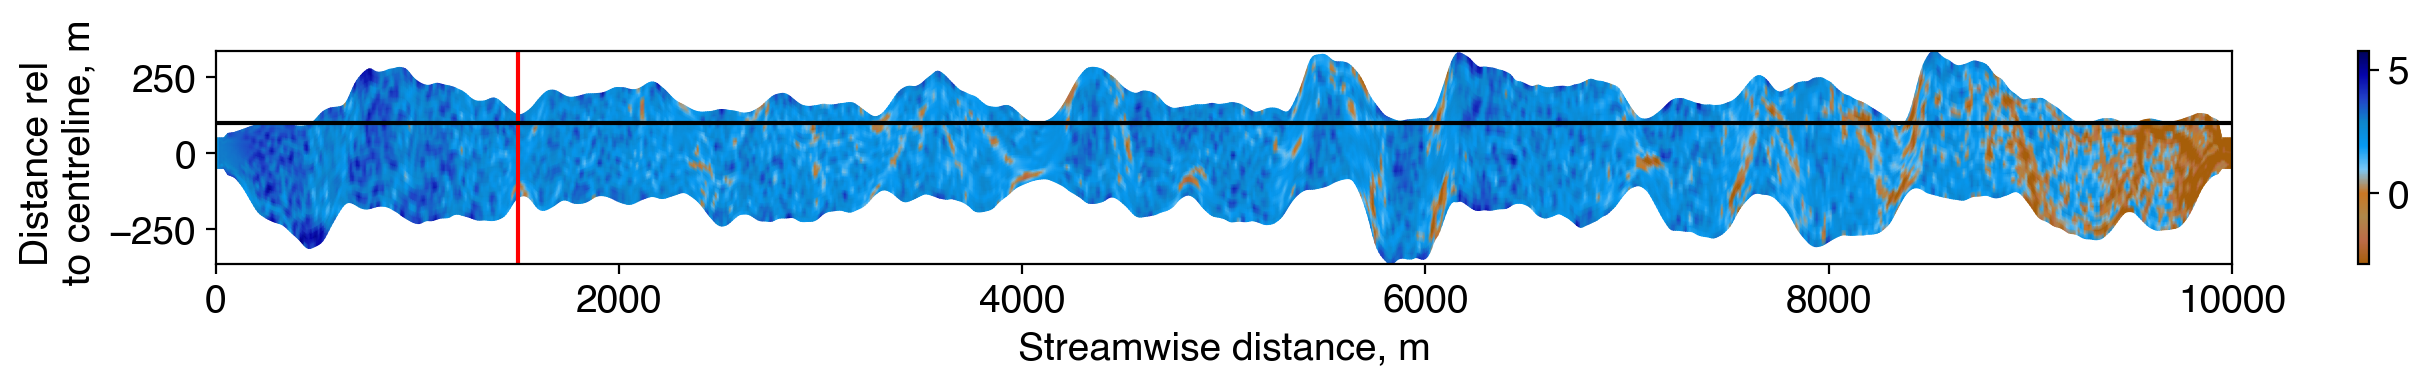

In [6]:
xdomain = np.reshape(datamaster[:, 2, -1], (gridy, gridx))
ydomain = np.reshape(datamaster[ :, 3, -1] , (gridy, gridx))
# elev_final = np.reshape(datamaster[:, 9, -1]/tcrit, (gridy, gridx)) 
elev_final = np.reshape(datamaster[:, 7, -1], (gridy, gridx))

test = ['a75e09','bd6c48', 'af884a', 'cb7723','7bc8f6','069af3', '0e87cc', '2242c77', '0504aa', '00035b'] 

#midnorm = MidpointNormalize(vmin=0, vcenter=1, vmax=20) 
# midnorm = mcol.TwoSlopeNorm(vmin = 0, vcenter = 2, vmax = 20)
midnorm = mcol.TwoSlopeNorm(vmin=-1, vcenter=0.5, vmax=6) 
fig, ax = plt.subplots(1, figsize = (14, 2), tight_layout = True, dpi = 200)
fig.subplots_adjust(hspace=.1)

ax.axvline(1500, c ='r')
ax.set_ylabel('Distance rel \n to centreline, m')
ax.set_xlabel('Streamwise distance, m')

dat = ax.pcolormesh(xdomain, ydomain, elev_final, cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)
# dat = ax.pcolormesh(xdomain[1:, :], ydomain[1:, :], cellQ, cmap = 'hsv', shading = 'gouraud', alpha = 1)
plt.colorbar(dat, ax = ax)
# plt.plot(np.arange(0, 10001, 10), np.sum(cellQ, axis =0))
plt.axhline(100, c='k')

Calculate the approximate wetted width at each cross section location at each timestep. This works by finding first the average water surface across the cross sections per time (NAYS draws the water surface over the bars that are subaerially exposed so the average gives the actual WS), then finds the y positions where the bed elevation exceeds the water surface (i.e. how we can define wet vs dry). Since the interpolation is done at 1m increments, every y position is about 1m apart and we can just find the number of y points that exceed the surface elevation and subtract that width from the channel width. This results in a [xpos, time] shaped array with wetted width for each location in time. Kinda scrappy but it works!

In [9]:
## indexing is correct-SA 11/8/22
## make x, y and water surface data in a grid like the channel, with time on the z axis
x_allt = np.reshape(datamaster[:, 2, :], (gridy, gridx, time))
y_allt = np.reshape(datamaster[:, 3, :], (gridy, gridx, time))
z_allt = np.reshape(datamaster[:, 7, :], (gridy, gridx, time))## bed elevation
wse_allt = np.reshape(datamaster[:, 7, :], (gridy, gridx, time)) + np.reshape(datamaster[:, 4, :], (gridy, gridx, time))
wse_xs = np.average(wse_allt, axis = 0) ## water surface elevation for each cross section, with time on z

In [10]:
channelmap = np.ones_like(x_allt)

In [11]:
widths = np.subtract(y_allt[-1, :, :], y_allt[0, :, :])
maxcw = widths.max()
beltdim = [int(np.round(maxcw, 0)), gridx, time]


In [20]:
wetwhere

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

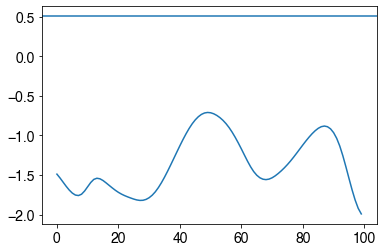

In [22]:
plt.plot(zinterp)
plt.axhline(wse_xs[x, t])

In [19]:
wet_width_master = np.empty_like(wse_xs)
active_chans = np.empty_like(wse_xs)
wet_binary = np.zeros(beltdim)
for t in range (379, 381):#time):## time first
    if t==100:
        print("It is running gurl, b patient")
    if t==200:
        print('Getting there, almost done')
    if t==time-1:
        print('Okay, fin!!')
    for x in range (0, gridx): ## amount of x positions
        xs_length = int(y_allt[-1, x, t]-y_allt[0, x, t])
        pos = np.arange(0, xs_length+1) ##make m scale array of x positions
        pos_2int = y_allt[:, x, t].astype(int) ## get values of the actual y positions
        fy = interpolate.interp1d(pos_2int, y_allt[:, x, t], kind = 'cubic', fill_value = 'extrapolate')
        fz = interpolate.interp1d(pos_2int, z_allt[:, x, t], kind = 'cubic', fill_value = 'extrapolate')
        
        datrange = np.arange(pos_2int[0], pos_2int[-1], dtype = int)
        
        # interpolate over y and z
        yinterp = fy(datrange)
        zinterp = fz(datrange)
        
        ## count number of y values where water level is more than the average (so above water)
        wet_width_master[x, t] = (yinterp[-1]-yinterp[0])-len(zinterp[zinterp>=wse_xs[x, t]])

        wetwhere = np.where(zinterp<=wse_xs[x, t])[0]
        wet_binary[wetwhere, x, t] = 1## put ones where wet
        # print(x, t, wetwhere)

        #actives = yinterp[zinterp>=wse_xs[x, t]]
        #actives = np.insert(yinterp[zinterp>=wse_xs[x, t]], 0, yinterp[0])
        
        ## find y values at these z lovations, add the values for the two banks of the channel belts
        actives = np.append(np.insert(yinterp[zinterp>=wse_xs[x, t]], 0, yinterp[0]), yinterp[-1]) ## find y values where above water, add channel bounds 
        # print(actives)
        # print(actives[1:]-actives[:-1])
        # indices should have a difference of more than 1m oso find where the difference is more than 1.5 (absolutely)
        active_chans[x, t] = np.count_nonzero(np.logical_or((actives[1:]-actives[:-1]) > 1.5, (actives[1:]-actives[:-1]) < -1.5))
        # print(active_chans[x, t])

Because I dont want to map bar preservation at the turnover timesclae in multiple sections, let's first look at bed elevation change in the sections

In [6]:
perc_untouched = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2_percent_untouched.npy', allow_pickle = True)

In [15]:
perc_untouched_mean = 1-(((1-perc_untouched)*maxcw)/(np.mean(y_allt[-1, :, adjustment_time:]-y_allt[0, :, adjustment_time:])))
maxcw_xs = (y_allt[-1, :, :]-y_allt[0, :, :]).max(axis = 1)
maxcw_xs = np.expand_dims(maxcw_xs, axis = 1)
# perc_untouched_lcl = 1-np.multiple((1-perc_untouched)*maxcw, maxcw_xs)##percentage untouched relative to cross ection max width
perc_untouched_lcl = 1-(((1-perc_untouched)*maxcw)/maxcw_xs)
perc_touched_lcl = 1-perc_untouched_lcl

In [16]:
elechange = z_allt[:, :, 1:]-z_allt[:, :, :-1] ## dz at each location
avgdz = np.average(elechange, axis = 0) ## avg dz per section
skewness_pertime = stats.skew(elechange, axis = 0)

In [12]:
# perc_dry = 1-np.divide(np.sum(wet_binary, axis = 0), maxcw_xs)

NameError: name 'wet_binary' is not defined

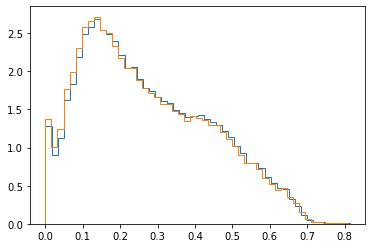

In [29]:
plt.hist(perc_dry[:, adjustment_time:].ravel(), bins = 50, histtype = 'step', density = True);
plt.hist(perc_untouched_lcl[:, adjustment_time:].ravel(), bins = 50, histtype = 'step', density = True);
# np.where(perc_untouched_lcl.max())
# plt.hist(np.divide((1-perc_untouched)*maxcw, maxcw_xs).ravel())

In [30]:
## manually mapped bars in 250 at 16 timestep turnover timescale (so the mean TT)

timestep = np.arange(80, 382, 16)
timestep = np.append(timestep, [382])

numfp_250 = np.array([1, 0, 3, 1, 1, 1, 2, 5, 2, 0, 0, 0, 0, 0, 2, 2, 3, 2, 3, 4])
numpp_250 = np.array([4, 4, 2, 3, 3, 0, 2, 5, 7, 5, 5, 5, 3, 5, 4, 3, 3, 3, 2, 2])
numtr_250 = np.array([12, 15, 11, 12, 9, 14, 15, 12, 13, 13, 11, 12, 15, 14, 15, 14, 14, 14, 15, 12])
total_250 = numfp_250+numpp_250+numtr_250
perc_fppp_250 = (numfp_250+numpp_250)/total_250
perc_fp_250 = numfp_250/total_250

numfp_300 = np.array([3, 1, 1, 2, 2, 4, 4, 3, 1, 2, 1, 1, 0, 1, 0, 0, 3, 2, 2, 4])
numpp_300 = np.array([2, 1, 1, 0, 0, 1, 2, 2, 3, 1, 2, 2, 3, 3, 3, 4, 2, 2, 2, 2])
numtr_300 = np.array([9, 11, 12, 10, 14, 10, 11, 10, 12, 12, 15, 14, 17, 16, 16, 15, 15, 13, 13, 11])
total_300 = numfp_300+numpp_300+numtr_300
perc_fppp_300 = (numfp_300+numpp_300)/total_300
perc_fp_300 = numfp_300/total_300

numfp_600 = np.array([0, 0, 2, 0, 0, 2, 1, 0, 1, 1, 3, 4, 3, 3, 2, 3, 1, 3, 3, 2])
numpp_600 = np.array([2, 3, 2, 2, 2, 2, 2, 5, 4, 5, 3, 3, 1, 2, 2, 2, 1, 1, 2, 2])
numtr_600 = np.array([5, 9, 8, 7, 7, 6, 8, 5, 8, 8, 9, 9, 8, 8, 10, 12, 10, 10, 10, 10])
total_600 = numfp_600+numpp_600+numtr_600
perc_fppp_600 = (numfp_600+numpp_600)/total_600
perc_fp_600 = numfp_600/total_600


In [38]:
## manually mapped bars in 250 at 16 timestep turnover timescale (so the mean TT)

timestep = np.arange(80, 382, 16)
timestep = np.append(timestep, [382])

numfp_340 = np.array([0, 0, 1, 2, 2, 2, 1, 1, 2, 2, 5, 5, 6, 3, 3, 7, 6, 4, 6, 6])
numpp_340 = np.array([1, 1, 1, 1, 2, 1, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1])
numtr_340 = np.array([4, 4, 3, 3, 3, 4, 5, 9, 11, 12, 11, 8, 7, 8, 9, 9, 9, 9, 7, 5])
total_340 = numfp_340+numpp_340+numtr_340
perc_fppp_340 = (numfp_340+numpp_340)/total_340
perc_fp_340 = numfp_340/total_340


numfp_370 = np.array([2, 1, 4, 1, 2, 0, 0, 3, 3, 4, 1, 0, 0, 0, 0, 2, 3, 2, 4, 0])
numpp_370 = np.array([1, 1, 1, 3, 1, 0, 3, 0, 0, 0, 3, 3, 1, 1, 1, 1, 0, 1, 0, 2])
numtr_370 = np.array([2, 7, 5, 4, 8, 1, 7, 12, 9, 10, 10, 11, 15, 15, 14, 14, 15, 12, 14, 16])
total_370 = numfp_370+numpp_370+numtr_370
perc_fppp_370 = (numfp_370+numpp_370)/total_370
perc_fp_370 = numfp_370/total_370



In [ ]:
fig, ax = plt.subplots(2, 1, tight_layout = True, sharex = False, sharey = True, dpi = 200, figsize = (8, 5))
# fig.suptitle('% of channel positions never touched by water, relative to local XS width')
ax[-1].set_xlabel('Timesteps')
ax[0].set_ylabel('proportion')
ax[1].set_ylabel('proportion')

# '#e08266', '#8da0ae'
ax[0].plot(np.arange(adjustment_time, time, 16), perc_touched_lcl[340, adjustment_time::16], marker = 'v', mfc = '#e08266', mew = .75, mec = 'k', ms = 11, lw = 0, label = '250 % untouched')
ax[0].plot(timestep, perc_fppp_340, marker = 'v', mfc = 'w', mew = .75, mec = 'k', ms = 11, lw = 0, label = '340 % preserved')

ax[0].set_ylim(0, 1)

ax[0].plot(np.arange(adjustment_time, time, 16), perc_touched_lcl[370, adjustment_time::16], marker = 'o', mfc = '#8da0ae', mew = .75, mec = 'k', ms = 10, lw = 0, label = '300 % untouched')
ax[0].plot(timestep, perc_fppp_370, marker = 'o', mfc = 'w', mew = .75, mec = 'k', ms = 10, lw = 0, label = '370 % preserved')

ax[0].set_xlim(75, 390)

# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/reworking_2x.png', transparent = True)

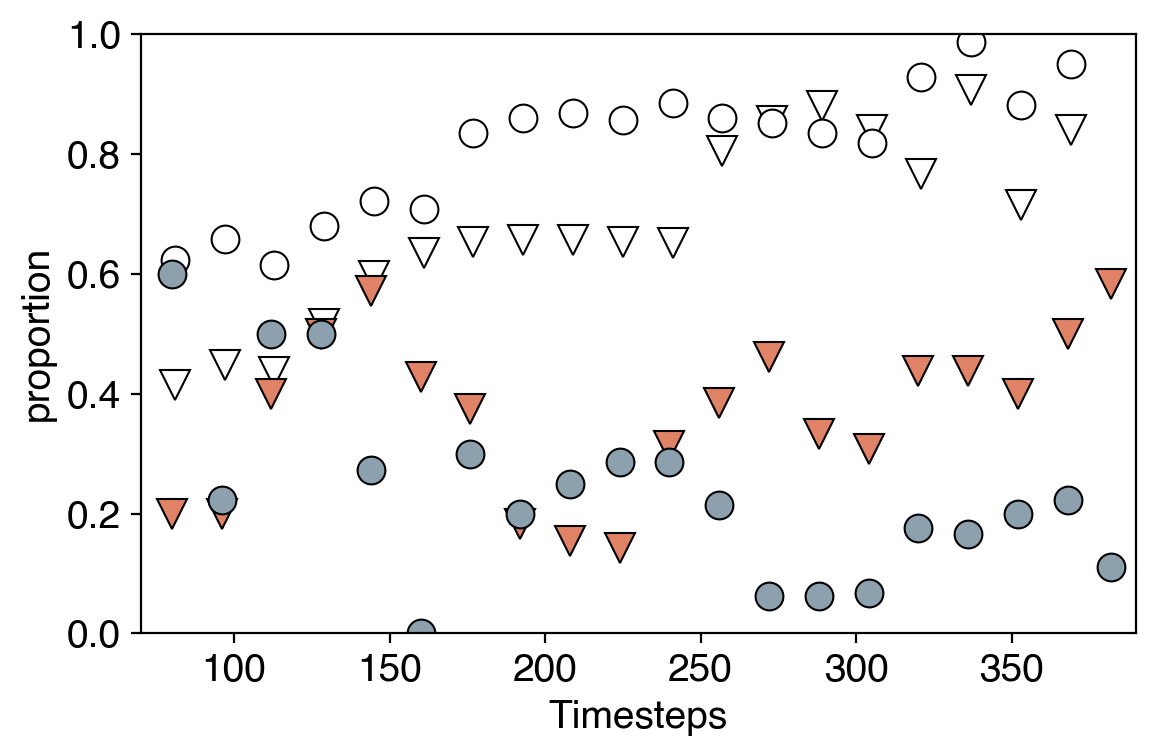

In [66]:
fig, ax = plt.subplots(1, tight_layout = True, sharex = True, sharey = True, dpi = 200, figsize = (6, 4))
# fig.suptitle('% of channel positions never touched by water, relative to local XS width')
ax.set_xlabel('Timesteps')
ax.set_ylabel('proportion')
# ax[1].set_ylabel('proportion')

# '#e08266', '#8da0ae'
ax.plot(np.arange(adjustment_time, time, 16), perc_touched_lcl[340, adjustment_time::16], marker = 'v', mfc = 'w', mew = .75, mec = 'k', ms = 11, lw = 0, label = '250 % untouched')
ax.plot(timestep, perc_fppp_340, marker = 'v', mfc = '#e08266', mew = .75, mec = 'k', ms = 11, lw = 0, label = '340 % preserved')

ax.set_ylim(0, 1)

ax.plot(np.arange(adjustment_time, time, 16), perc_touched_lcl[370, adjustment_time::16], marker = 'o', mfc = 'w', mew = .75, mec = 'k', ms = 10, lw = 0, label = '300 % untouched')
ax.plot(timestep, perc_fppp_370, marker = 'o', mfc = '#8da0ae', mew = .75, mec = 'k', ms = 10, lw = 0, label = '370 % preserved')

ax.set_xlim(70, 390)

plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/reworking_1x.png', transparent = True)

(0.0, 6.0)

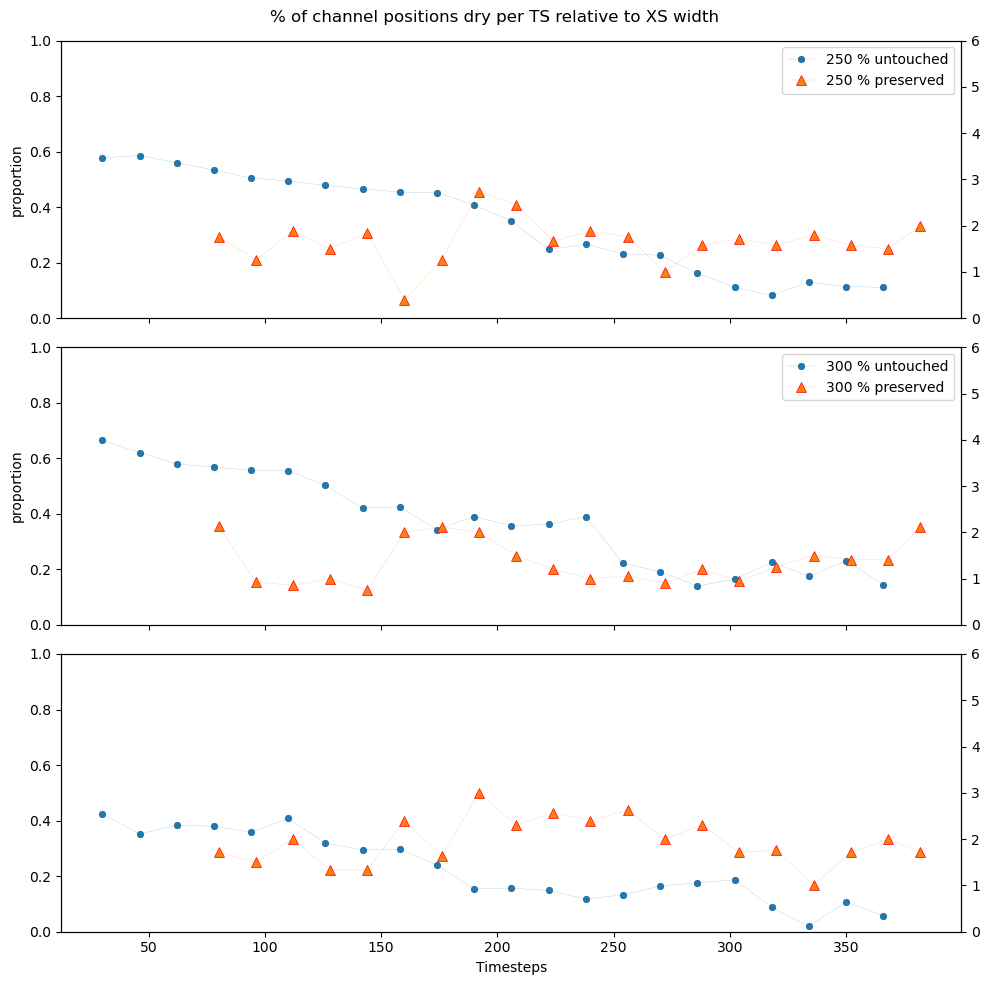

In [33]:
fig, ax = plt.subplots(3, 1, tight_layout = True, sharex = True, sharey = True, dpi = 100, figsize = (10, 10))
fig.suptitle('% of channel positions dry per TS relative to XS width')
ax[-1].set_xlabel('Timesteps')
ax[0].set_ylabel('proportion')
ax[1].set_ylabel('proportion')
ax[0].plot(np.arange(adjustment_time, time, 16), perc_dry[250, adjustment_time::16], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0.1, label = '250 % untouched')
ax[1].plot(np.arange(adjustment_time, time, 16), perc_dry[340, adjustment_time::16], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0.1, label = '300 % untouched')
ax[2].plot(np.arange(adjustment_time, time, 16), perc_dry[370, adjustment_time::16], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0.1, label = '600 % untouched')

# plt.plot(np.arange(adjustment_time, time, 16), perc_untouched[550, adjustment_time::16], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0.1, label = '550')
# plt.plot(np.arange(adjustment_time, time, 16), perc_untouched[600, adjustment_time::16], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0.1, label = '600')
# plt.plot(np.arange(adjustment_time, time, 16), perc_untouched[350, adjustment_time::16], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0.1, label = '350')
# plt.plot(np.arange(adjustment_time, time, 16), perc_untouched[650, adjustment_time::16], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0.1, label = '650')
# plt.plot(np.arange(adjustment_time, time), perc_untouched[250, adjustment_time:], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '250')
# plt.plot(np.arange(adjustment_time, time), perc_untouched[300, adjustment_time:], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '300')
# plt.plot(np.arange(adjustment_time, time), perc_untouched[550, adjustment_time:], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '550')
# plt.plot(np.arange(adjustment_time, time), perc_untouched[600, adjustment_time:], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '600')

# plt.ylim(0, 1)
ax0r = ax[0].twinx()
ax1r = ax[1].twinx()
ax2r = ax[2].twinx()

# ax0r.plot(np.arange(adjustment_time, time, 16), active_chans[250, adjustment_time::16])
# ax1r.plot(np.arange(adjustment_time, time, 16), active_chans[300, adjustment_time::16])
# ax2r.plot(np.arange(adjustment_time, time, 16), active_chans[600, adjustment_time::16])
# ax = plt.gca()
# ax0r = ax[0].twinx()
# ax0r = ax[0].twinx()
ax[0].set_ylim(0, 1)
ax[0].plot(timestep, perc_fppp_250, marker = '^', mew = 0.5, mec = 'r', ms = 7, lw = 0.1, label = '250 % preserved')
ax[1].plot(timestep, perc_fppp_300, marker = '^', mew = 0.5, mec = 'r', ms = 7, lw = 0.1, label = '300 % preserved')
ax[2].plot(timestep, perc_fppp_600, marker = '^', mew = 0.5, mec = 'r', ms = 7, lw = 0.1, label = '600 % preserved')
# ax[0].set_ylabel('% of preserved (PP and FP) bars')
# ax1.plot(np.arange(adjustment_time, time-1), avgdz[250, adjustment_time:], marker = '^', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '250')
# ax1.plot(np.arange(adjustment_time, time-1), skewness_pertime[300, adjustment_time:], marker = '^', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '300')
# ax1.plot(np.arange(adjustment_time, time-1), skewness_pertime[550, adjustment_time:], marker = '^', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '550')
# ax1.plot(np.arange(adjustment_time, time-1), skewness_pertime[600, adjustment_time:], marker = '^', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '600')

ax[0].legend()
ax[1].legend()
ax0r.set_ylim(0, 6)
ax1r.set_ylim(0, 6)
ax2r.set_ylim(0, 6)

(0.0, 6.0)

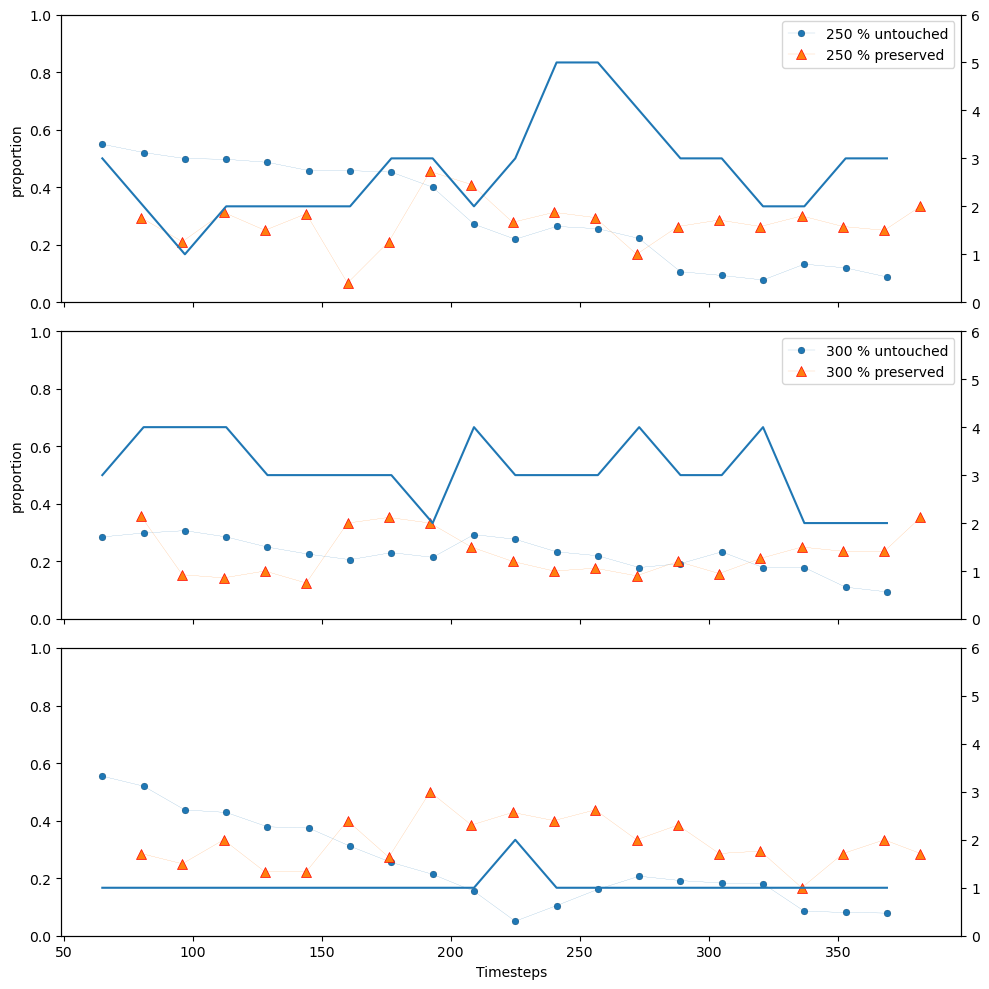

In [160]:
fig, ax = plt.subplots(3, 1, tight_layout = True, sharex = True, sharey = True, dpi = 100, figsize = (10, 10))

ax[-1].set_xlabel('Timesteps')
ax[0].set_ylabel('proportion')
ax[1].set_ylabel('proportion')
ax[0].plot(np.arange(adjustment_time, time, 16), perc_untouched_lcl[250, adjustment_time::16], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0.1, label = '250 % untouched')
ax[1].plot(np.arange(adjustment_time, time, 16), perc_untouched_lcl[300, adjustment_time::16], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0.1, label = '300 % untouched')
ax[2].plot(np.arange(adjustment_time, time, 16), perc_untouched_lcl[600, adjustment_time::16], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0.1, label = '600 % untouched')

# plt.plot(np.arange(adjustment_time, time, 16), perc_untouched[550, adjustment_time::16], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0.1, label = '550')
# plt.plot(np.arange(adjustment_time, time, 16), perc_untouched[600, adjustment_time::16], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0.1, label = '600')
# plt.plot(np.arange(adjustment_time, time, 16), perc_untouched[350, adjustment_time::16], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0.1, label = '350')
# plt.plot(np.arange(adjustment_time, time, 16), perc_untouched[650, adjustment_time::16], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0.1, label = '650')
# plt.plot(np.arange(adjustment_time, time), perc_untouched[250, adjustment_time:], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '250')
# plt.plot(np.arange(adjustment_time, time), perc_untouched[300, adjustment_time:], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '300')
# plt.plot(np.arange(adjustment_time, time), perc_untouched[550, adjustment_time:], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '550')
# plt.plot(np.arange(adjustment_time, time), perc_untouched[600, adjustment_time:], marker = 'o', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '600')

# plt.ylim(0, 1)
ax0r = ax[0].twinx()
ax1r = ax[1].twinx()
ax2r = ax[2].twinx()

ax0r.plot(np.arange(adjustment_time, time, 16), active_chans[250, adjustment_time::16])
ax1r.plot(np.arange(adjustment_time, time, 16), active_chans[300, adjustment_time::16])
ax2r.plot(np.arange(adjustment_time, time, 16), active_chans[600, adjustment_time::16])
# ax = plt.gca()
# ax0r = ax[0].twinx()
# ax0r = ax[0].twinx()
ax[0].set_ylim(0, 1)
ax[0].plot(timestep, perc_fppp_250, marker = '^', mew = 0.5, mec = 'r', ms = 7, lw = 0.1, label = '250 % preserved')
ax[1].plot(timestep, perc_fppp_300, marker = '^', mew = 0.5, mec = 'r', ms = 7, lw = 0.1, label = '300 % preserved')
ax[2].plot(timestep, perc_fppp_600, marker = '^', mew = 0.5, mec = 'r', ms = 7, lw = 0.1, label = '600 % preserved')
# ax[0].set_ylabel('% of preserved (PP and FP) bars')
# ax1.plot(np.arange(adjustment_time, time-1), avgdz[250, adjustment_time:], marker = '^', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '250')
# ax1.plot(np.arange(adjustment_time, time-1), skewness_pertime[300, adjustment_time:], marker = '^', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '300')
# ax1.plot(np.arange(adjustment_time, time-1), skewness_pertime[550, adjustment_time:], marker = '^', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '550')
# ax1.plot(np.arange(adjustment_time, time-1), skewness_pertime[600, adjustment_time:], marker = '^', mew = 0.1, mec = 'k', ms = 5, lw = 0, label = '600')

ax[0].legend()
ax[1].legend()
ax0r.set_ylim(0, 6)
ax1r.set_ylim(0, 6)
ax2r.set_ylim(0, 6)

In [20]:
active_chans.shape

(1001, 382)

In [62]:
# arrayname = #agubh2WWmaster
# np.save('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2_percent_untouched.npy', perc_untouched, allow_pickle = True)
# np.save('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2WWmaster-ud.npy', wet_width_master, allow_pickle = True)
# np.save('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2_active_channels-ud.npy', active_chans, allow_pickle = True)

### Some plots exploring the width data

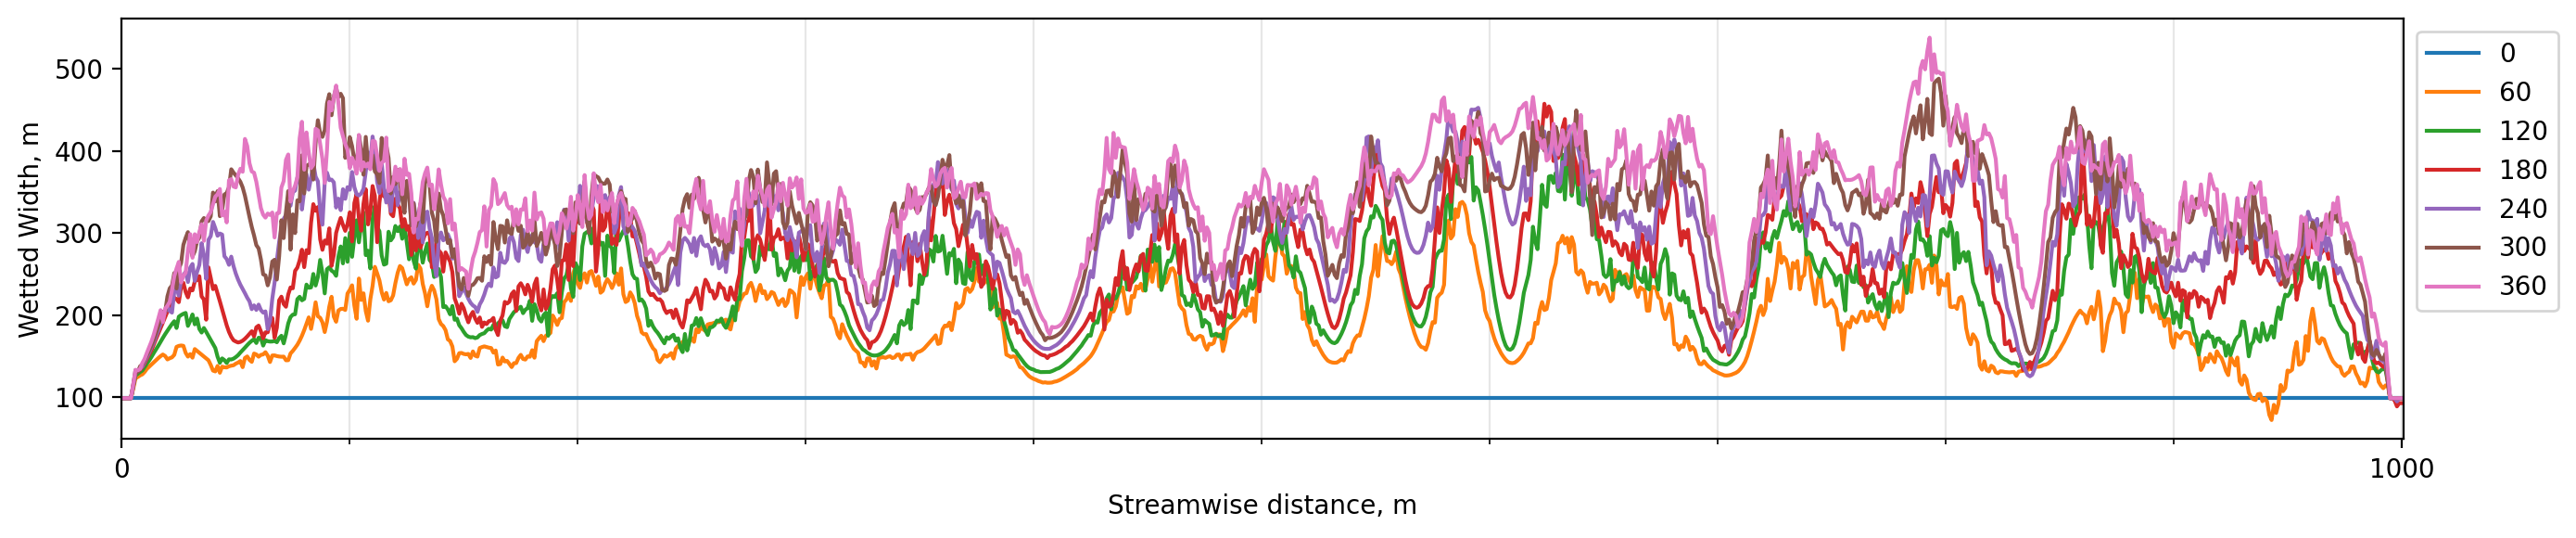

In [122]:
plt.figure(figsize = (14, 3), dpi = 200, tight_layout = True)
for i in [0, 60, 120, 180, 240, 300, 360]:
    plt.plot(np.arange(0, len(wet_width_master)), wet_width_master[:, i], label = i)
plt.legend(bbox_to_anchor=[1,1])
plt.xlabel('Streamwise distance, m')
plt.ylabel('Wetted Width, m')
plt.xlim(0, 1001)
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.xaxis.set_major_locator(MultipleLocator(1000))

ax.grid(axis = 'x', which = 'both', alpha = 0.3)

(1.0, 6.0)

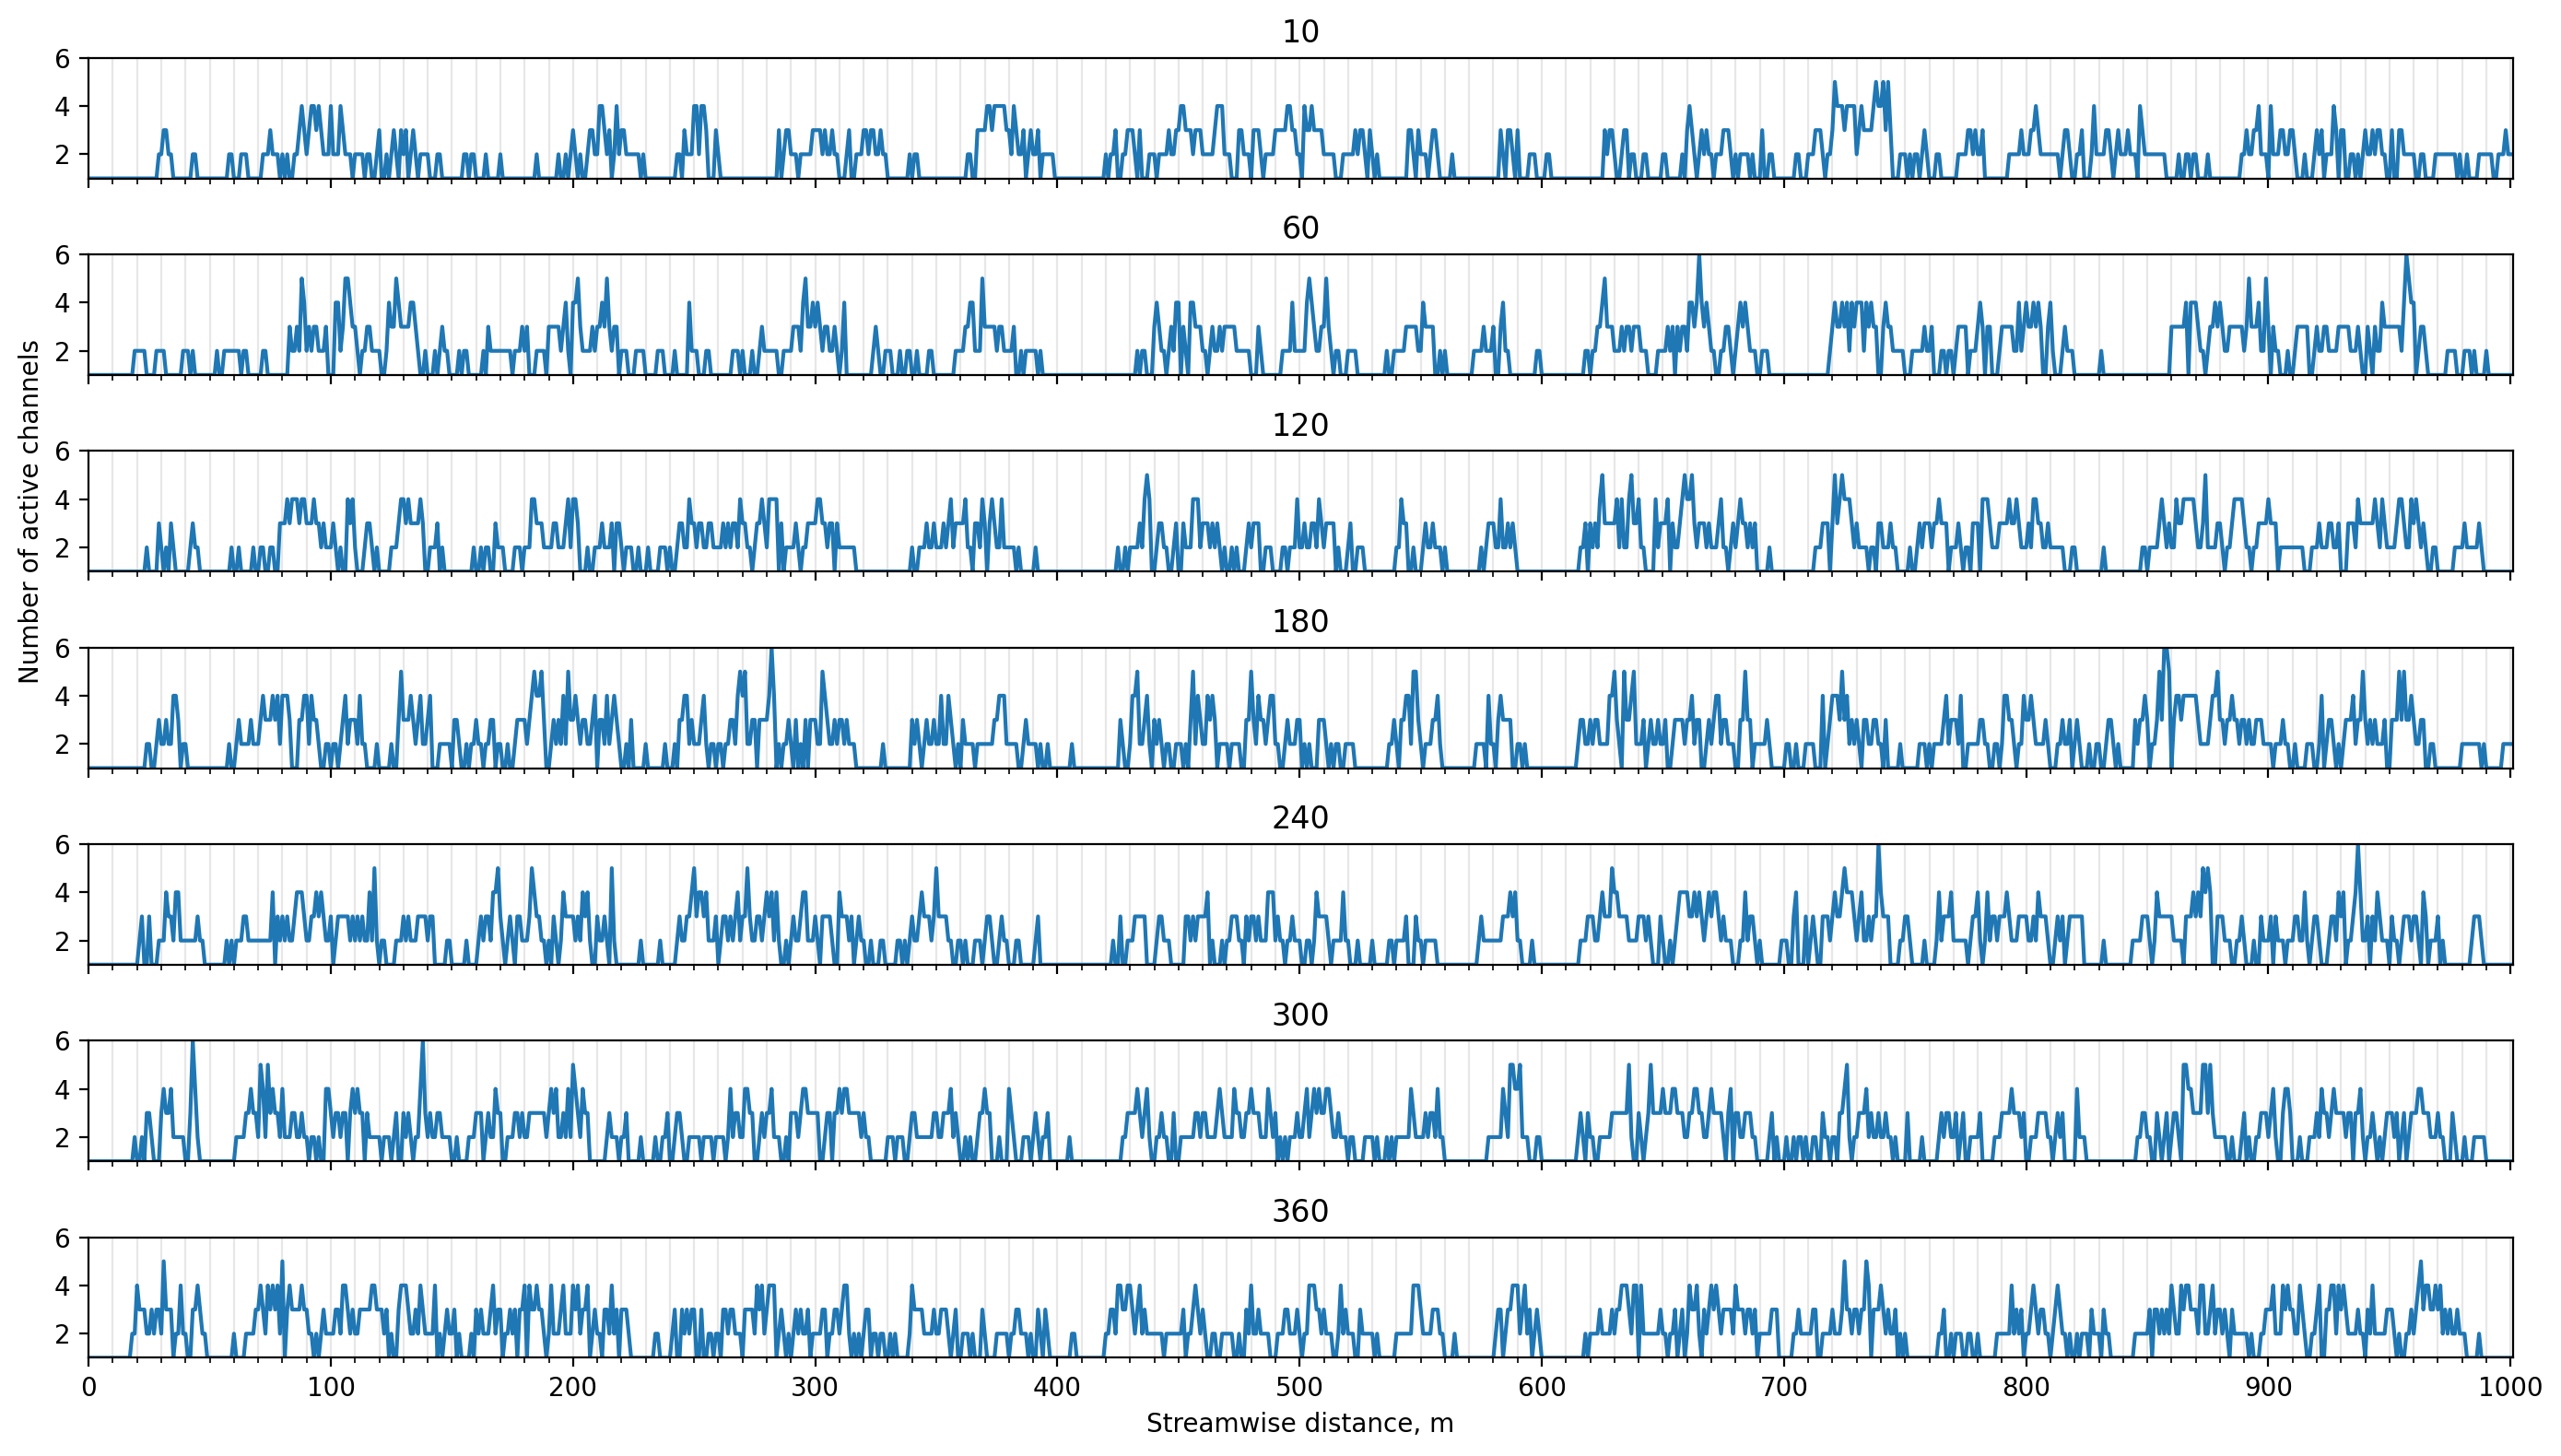

In [123]:
timeseries = [10, 60, 120, 180, 240, 300, 360]
fig, ax = plt.subplots(len(timeseries), figsize = (14, 8), dpi = 200, tight_layout = True, sharex = True, sharey = True)

for a, t in enumerate(timeseries):
    ax[a].plot(np.arange(0, len(active_chans)), active_chans[:, t])
    ax[a].xaxis.set_minor_locator(MultipleLocator(10))
    ax[a].xaxis.set_major_locator(MultipleLocator(100))
    
    ax[a].yaxis.set_major_locator(MultipleLocator(2))

    ax[a].grid(axis = 'x', which = 'both', alpha = 0.3)
    ax[a].set_title(t)
# plt.legend(bbox_to_anchor=[1,1])
plt.xlabel('Streamwise distance, m')
ax[2].set_ylabel('Number of active channels')
plt.xlim(0, 1001)
# ax = plt.gca()
ax[-1].set_ylim(1, 6)


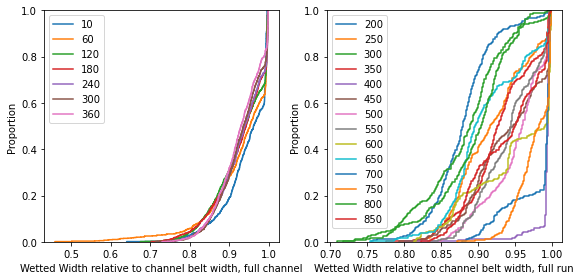

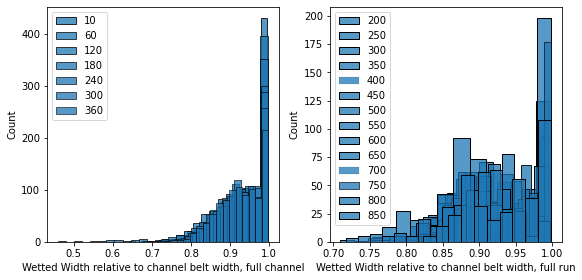

In [124]:
## how wetted width scales with channel belt width 
ch_w = y_allt[-1, :, :]-y_allt[0, :, :] ## section wise channel widths
belt_to_ww = wet_width_master/ch_w
fig, ax = plt.subplots(1, 2, figsize = (8, 4), tight_layout = True)
for t in timeseries:
    sns.ecdfplot(belt_to_ww[:, t], label = t, ax = ax[0])
ax[0].set_xlabel('Wetted Width relative to channel belt width, full channel') 
ax[0].legend()

xslocs = np.arange(200, 900, 50)
for xs in xslocs:
    sns.ecdfplot(belt_to_ww[xs, :], label = xs, ax = ax[1])
ax[1].set_xlabel('Wetted Width relative to channel belt width, full run') 
ax[1].legend()

fig, ax = plt.subplots(1, 2, figsize = (8, 4), tight_layout = True)
for t in timeseries:
    sns.histplot(belt_to_ww[:, t], label = t, ax = ax[0])
ax[0].set_xlabel('Wetted Width relative to channel belt width, full channel') 
ax[0].legend()

# xslocs = np.arange(200, 900, 50)
for xs in xslocs:
    sns.histplot(belt_to_ww[xs, :], label = xs, ax = ax[1])
ax[1].set_xlabel('Wetted Width relative to channel belt width, full run') 
ax[1].legend()


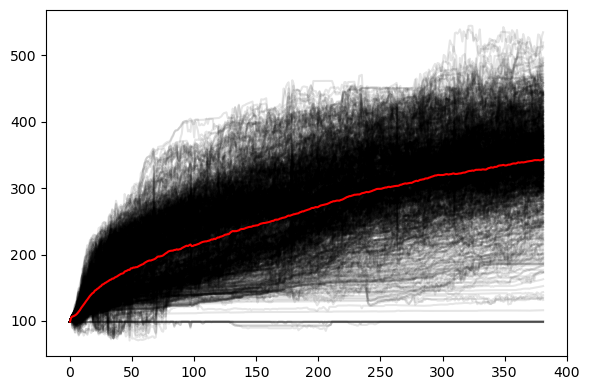

In [125]:
plt.figure(figsize = (6, 4), tight_layout = True, dpi = 100)
# for xs in xslocs:
#     sns.displot(x = wet_width_master[xs, :], y = active_chans[xs, :])

# sns.displot(x = wet_width_master[:, 360], y = active_chans[:, 360])
for i in range (0, len(wet_width_master)):
    plt.plot(wet_width_master[i, :], c = 'k', alpha = 0.1)
plt.plot(np.average(wet_width_master, axis = 0), 'r')

In [109]:
np.average(wet_width_master, axis = 0)[300:325]

array([319.6013462 , 319.92136624, 320.54728464, 321.04346978,
       320.87477913, 320.38036893, 320.9620067 , 321.03051656,
       321.73745915, 322.09067139, 343.20818624, 342.42804618,
       341.89474626, 341.83428937, 342.24977524, 341.95259182,
       342.13244123, 342.00907388, 341.56666321, 340.97445293,
       340.77769954, 340.65692447, 340.24502942, 339.91227219,
       339.31066419])

### Trying to find cellular discharge...another shit show

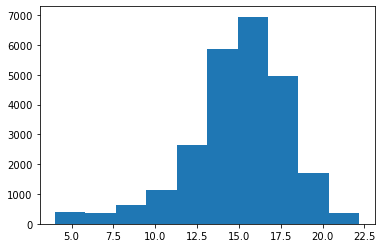

In [133]:
plt.hist(cellw.ravel());

In [139]:
## for cellular discharge have to find the values of width and depth and velocity along the middle of the cell, not the edges
cellw = ydomain[1:, :]-ydomain[:-1, :]

dep_faces = np.reshape(datamaster[:, 4, -1], (gridy, gridx))
celldep = 0.5*(dep_faces[1:, :]+dep_faces[:-1, :])

vel_faces = np.reshape(datamaster[:, 10, -1], (gridy, gridx))
cellvel = 0.5*(vel_faces[1:, :]+vel_faces[:-1, :])

cellQ = cellw*celldep*cellvel

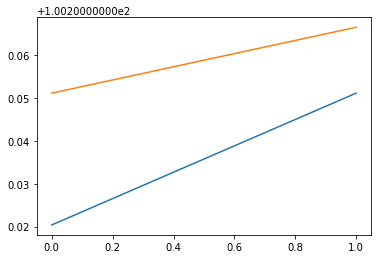

In [148]:
plt.plot(np.sum(cellQ, axis = 0)[:2])
plt.plot(np.sum(cellQ, axis = 0)[-2:])

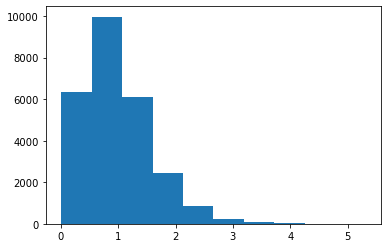

In [78]:
plt.hist(dep_faces.ravel());
# plt.hist(datamaster[:, 10, :].ravel(), histtype = 'step');

(array([184., 416., 187., 106.,  42.,  29.,  21.,  11.,   4.,   1.]),
 array([ 71.95553432, 133.03073535, 194.10593638, 255.18113741,
        316.25633845, 377.33153948, 438.40674051, 499.48194154,
        560.55714257, 621.63234361, 682.70754464]),
 <BarContainer object of 10 artists>)

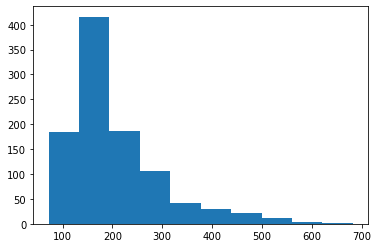

In [131]:
# plt.hist(cellQ.ravel());
plt.hist(np.sum(cellQ, axis =0))

Okay, most of the channel is above threshold throughout the model run so this isnt really a good channel predictor, at least for the plotting of the channel planform. 

0.02885834365568264
0.2598197724352


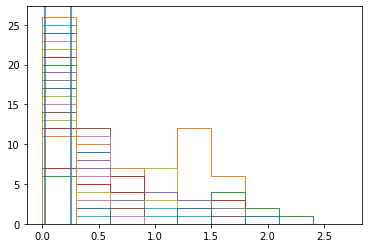

In [34]:
tcrit = 0.15*(0.00137**0.25)
print(tcrit)
for i in range (0, data.shape[2]):
    plt.hist(data[:, 9, i], histtype = 'step', bins = np.arange(0, 2.7, 0.3))
plt.axvline(tcrit)    
corresponding_velocities = data[:, 10, :][data[:, 9, :]<tcrit]
plt.axvline(np.quantile(corresponding_velocities, 0.90))

velcutoff = np.quantile(corresponding_velocities, 0.90)

In [12]:
data[:, 3, -1][-1*data[:, 7, -1] >= -0.1]

array([-139.82298798,  -78.59869119])

### 

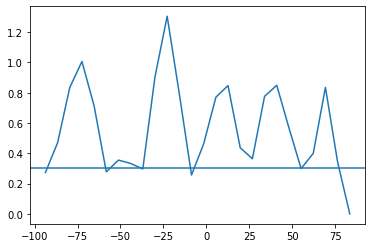

In [9]:
plt.plot(data[:, 3, 100], data[:, 10, 100])
plt.axhline(0.3)

In [45]:
xposition = np.arange(data[:, 3, 100].min(), data[:, 3, 100].max())
data_toint = 
velint = interpolate.interp1d(xposition, data[:, 3, 100], kind = 'cubic', fill_value = 'extrapolate')
velterm = fx(xposition)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [ ]:
   #print(shear[t, :][~np.isnan(shear[t, :])])
    #print(shearnotnan[:].shape, froudenotnan[:].shape, truefnotnan[:].shape, velnotnan[:].shape)
    #print(xposition[t, :])
    #print(dataint)
    fx = interpolate.interp1d(xposition[t, :], stratnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #stratigraphy interpolation
    #print(fx)
    fsh = interpolate.interp1d(xposition[t, :], shearnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #shear stress interpolation
    ffr = interpolate.interp1d(xposition[t, :], froudenotnan[:], kind = 'cubic', fill_value = 'extrapolate') #froude number interpolation
    ftf = interpolate.interp1d(xposition[t, :], truefnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #true flow depth interpolation
    #fsf = interpolate.interp1d(xposition[t, :], scalefnotnan[:], kind = 'cubic') #scaled flow depth interpolation
    ffv = interpolate.interp1d(xposition[t, :], velnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #flow veloity interpolation
    
    #print(fx(dataint))
    
    xy_topo[t, dataint] = fx(dataint) #reassign strat

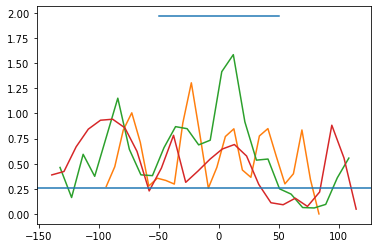

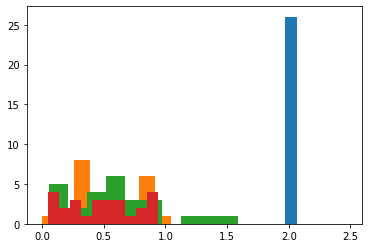

In [35]:
for i in range (0, data.shape[2], 100):
    plt.plot(data[:, 3, i], data[:, 10, i])
plt.axhline(velcutoff)
plt.figure()
for i in range (0, data.shape[2], 100):
    plt.hist(data[:, 10, i])


(array([1834.,  582.,    3.,    0.,    0.,    0.,    0.,    0.,    0.,
          26.]),
 array([0.        , 0.19681093, 0.39362185, 0.59043278, 0.78724371,
        0.98405463, 1.18086556, 1.37767649, 1.57448741, 1.77129834,
        1.96810926]),
 <BarContainer object of 10 artists>)

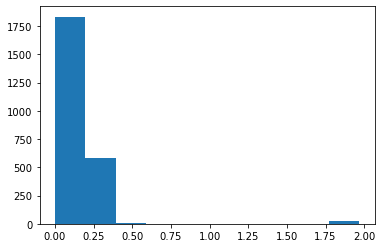

In [29]:
plt.hist(data[:, 10, :][data[:, 9, :]<tcrit])